## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on simulated P1D data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.archive import gadget_archive
from lace.emulator import gp_emulator
from cup1d.data import data_MPGADGET
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# add high-k measurement (will change emulator settings as well)
add_hires=False
if add_hires:
    kmax_Mpc=8
else:
    kmax_Mpc=3

In [4]:
# specify simulation suite and P1D mesurements
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(sim_label=test_sim_label,
                                zmax=z_max,
                                polyfit=(emu_type=="polyfit"))

In [5]:
# option to add extra P1D (high-resolution)
if add_hires:
    extra_data=data_MPGADGET.P1D_MPGADGET(sim_label=test_sim_label,
                                zmax=z_max,
                                polyfit=(emu_type=="polyfit"),
                                data_cov_label='Karacayli2022')
else:
    extra_data=None

### Emulator and training set

Create a set of training data to train an emulator

In [6]:
if drop_sim_number:
    raise ValueError("update notebook for leave-one-out")
# specify simulation suite and P1D mesurements
archive=gadget_archive.GadgetArchive(postproc='Pedersen21')

In [7]:
emu_params=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
kmax_Mpc=8
emu=gp_emulator.GPEmulator(archive=archive,emu_params=emu_params,
                                emu_type=emu_type,kmax_Mpc=kmax_Mpc)

Use custom archive provided by the user
Selected custom emulator
Training GP on 330 points


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.26 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [8]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=1
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [9]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

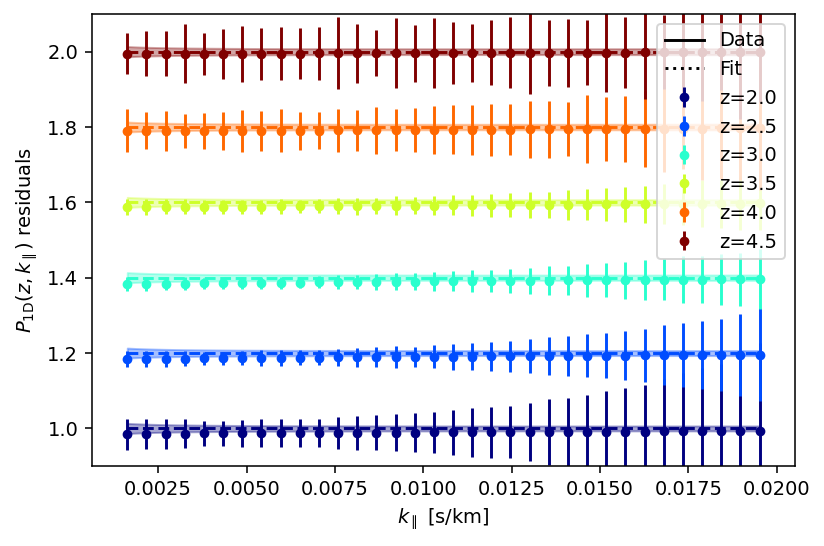

In [10]:
like.plot_p1d(residuals=True,plot_every_iz=2)

In [11]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=2)

# Try iminuit minimizer

In [12]:
test_values=len(free_param_names)*[0.5]
ini_chi2=like.get_chi2(values=test_values)
print('chi2 =',ini_chi2)

chi2 = 21.711308616135696


In [13]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [14]:
minimizer.minimize(compute_hesse=True)

In [15]:
best_fit_values=np.array(minimizer.minimizer.values)
best_chi2=like.get_chi2(values=best_fit_values)
print('chi2 improved from {} to {}'.format(ini_chi2,best_chi2))

chi2 improved from 21.711308616135696 to 0.07604727981797708


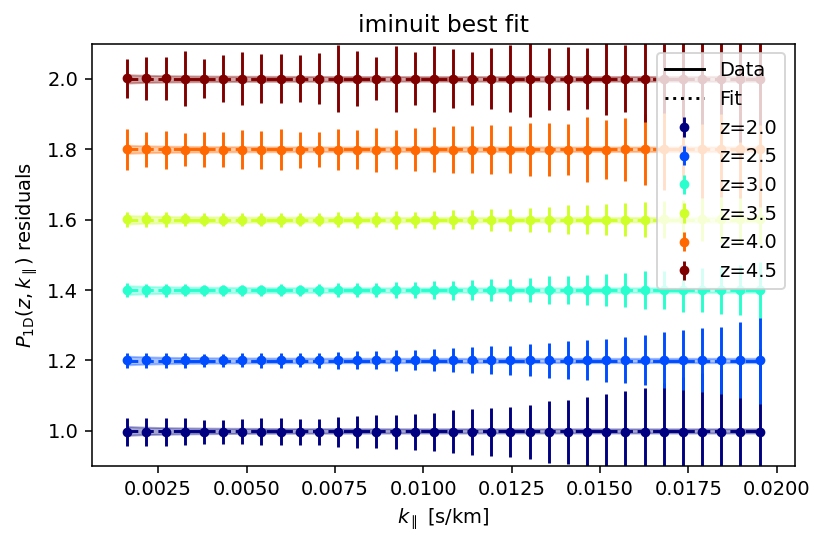

In [16]:
minimizer.plot_best_fit(plot_every_iz=2)

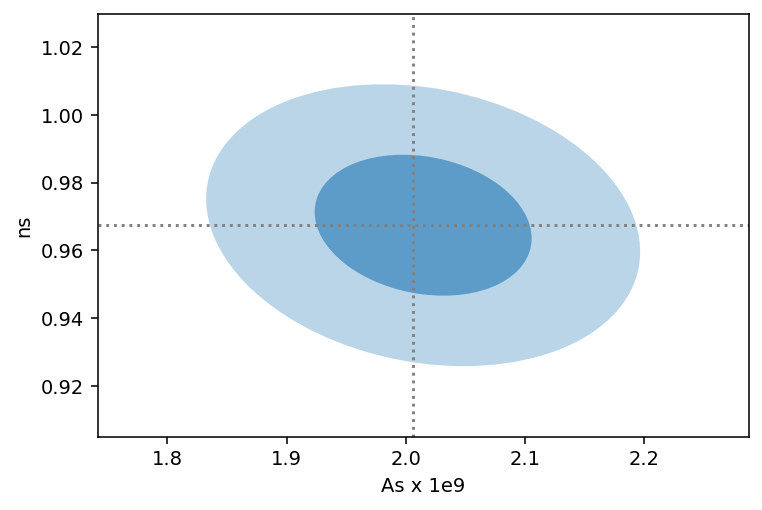

In [17]:
minimizer.plot_ellipses('As','ns')

### Access the actual minimizer object from iminuit

In [18]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 118.5                      │              Nfcn = 282              │
│ EDM = 7.35e-10 (Goal: 0.0001)    │            time = 6.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.46    │   0.04    │            │            │         │         │       │
│ 1 │ x1   │   0.51    │   0.12    │            │            │         │         │       │
│ 2 │ x2   │   0.50    │   0.27    │            │            │         │         │       │
│ 3 │ x3   │   0.50    │   0.16    │            │            │         │         │       │
│ 4 │ x4   │   0.49    │   0.24    │            │            │         │         │       │
│ 5 │ x5   │   0.50    │   0.17    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │    0.0017 -0.000915  0.000869  -0.00213   0.00309   0.00327 │
│ x1 │ -0.000915    0.0149   -0.0298     0.016   -0.0271   -0.0163 │
│ x2 │  0.000869   -0.0298    0.0743   -0.0417    0.0638    0.0367 │
│ x3 │  -0.00213     0.016   -0.0417    0.0263   -0.0369   -0.0244 │
│ x4 │   0.00309   -0.0271    0.0638   -0.0369    0.0596    0.0345 │
│ x5 │   0.00327   -0.0163    0.0367   -0.0244    0.0345    0.0282 │
└────┴─────────────────────────────────────────────────────────────┘

In [19]:
#minimizer.minimizer.draw_mncontour("x0", "x1")

In [20]:
#minimizer.minimizer.draw_mnprofile("x0")